In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Data Prep

In [3]:
def create_features(df):
    df = df.copy().sort_index()

    df['Close_rolling_mean_7'] = df['Close'].rolling(window=7).mean()
    df['Close_rolling_std_7'] = df['Close'].rolling(window=7).std()

    # Exponential Moving Average (EMA)
    df['Close_ema_7'] = df['Close'].ewm(span=7, adjust=False).mean()

    # Volume-based Features
    df['Volume_rolling_mean_7'] = df['Shares Traded'].rolling(window=7).mean()
    df['Volume_pct_change'] = df['Shares Traded'].pct_change()

    # VADER & Sentiment Features
    df['summary_vader_rolling_mean_7'] = df['summary_vader'].rolling(window=7).mean()
    df['summary_sentiment_rolling_mean_7'] = df['summary_sentiment'].rolling(window=7).mean()
    df['description_vader_rolling_mean_7'] = df['description_vader'].rolling(window=7).mean()
    df['description_sentiment_rolling_mean_7'] = df['description_sentiment'].rolling(window=7).mean()

    # Drop rows with NaN values created by lagging (optional)
    df = df.dropna()

    return df

In [4]:
news_df = pd.read_csv('../Dataset/aggregated/aggregated_news_data.csv', parse_dates=['market_date'], index_col='market_date')
news_df.head()

,news_count,summary_vader,summary_sentiment,description_vader,description_sentiment
market_date,,,,,
2024-05-01,4.0,0.753775,0.250000,0.233400,-0.50
2024-05-02,3.0,0.281233,0.333333,0.214233,0.00
2024-05-05,3.0,0.649033,0.000000,0.324667,0.00
2024-05-06,2.0,-0.440800,-1.000000,0.413600,0.00
2024-05-07,4.0,-0.063450,0.000000,0.359125,-0.25


In [5]:
market_df = pd.read_csv('../Dataset/stocks/preprocessed/NIFTY 50-26-10-2023-to-25-10-2024_preprocessing.csv', parse_dates=['Date'], index_col='Date')
market_df.head()

,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),Daily_Change,Daily_change_percent
Date,,,,,,,,
2023-10-26,19027.25,19041.70,18837.85,18857.25,300356469.0,28939.64,-170.00,-0.893455
2023-10-27,18928.75,19076.15,18926.65,19047.25,205201044.0,19947.48,118.50,0.626032
2023-10-30,19053.40,19158.50,18940.00,19140.90,180132492.0,17095.73,87.50,0.459236
2023-10-31,19232.95,19233.70,19056.45,19079.60,206049341.0,19397.36,-153.35,-0.797330
2023-11-01,19064.05,19096.05,18973.70,18989.15,194103279.0,18452.51,-74.90,-0.392886


In [6]:
work_df = pd.merge(news_df, market_df, left_index=True, right_index=True, how='inner')
work_df = create_features(work_df)
work_df.head()

/var/folders/8m/7v6gzd016pvd5cfs456xwjvc0000gn/T/ipykernel_46293/2654627384.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Volume_pct_change'] = df['Shares Traded'].pct_change()


,news_count,summary_vader,summary_sentiment,description_vader,description_sentiment,Open,High,Low,Close,Shares Traded,...,Daily_change_percent,Close_rolling_mean_7,Close_rolling_std_7,Close_ema_7,Volume_rolling_mean_7,Volume_pct_change,summary_vader_rolling_mean_7,summary_sentiment_rolling_mean_7,description_vader_rolling_mean_7,description_sentiment_rolling_mean_7
2024-05-13,2.0,0.64265,1.000000,0.509950,0.500000,22027.95,22131.65,21821.05,22104.05,278186886.0,...,0.345470,22258.950000,239.948955,22227.847827,3.166769e+08,0.046585,0.201805,-0.166667,0.307480,-0.107143
2024-05-14,3.0,0.58080,0.333333,0.127267,0.000000,22112.90,22270.05,22081.25,22217.85,230238941.0,...,0.474610,22197.471429,167.913345,22225.348370,2.858668e+08,-0.172359,0.244600,-0.166667,0.295056,-0.107143
2024-05-15,2.0,0.72260,0.500000,0.579400,0.000000,22255.60,22297.55,22151.75,22200.55,231935478.0,...,-0.247353,22162.878571,129.528063,22219.148778,2.732496e+08,0.007369,0.410800,0.047619,0.318742,-0.107143
2024-05-16,3.0,0.26910,0.333333,0.369133,0.666667,22319.20,22432.25,22054.55,22403.85,368945092.0,...,0.379270,22177.357143,151.531513,22265.324083,2.834110e+08,0.590723,0.458307,0.095238,0.320171,0.023810
2024-05-17,2.0,0.25210,0.500000,0.431000,0.500000,22415.25,22502.15,22345.65,22466.10,242654570.0,...,0.226854,22200.728571,183.329819,22315.518062,2.784418e+08,-0.342302,0.437214,0.166667,0.358150,0.166667


In [7]:
work_df.columns

Index(['news_count', 'summary_vader', 'summary_sentiment', 'description_vader',
       'description_sentiment', 'Open', 'High', 'Low', 'Close',
       'Shares Traded', 'Turnover (₹ Cr)', 'Daily_Change',
       'Daily_change_percent', 'Close_rolling_mean_7', 'Close_rolling_std_7',
       'Close_ema_7', 'Volume_rolling_mean_7', 'Volume_pct_change',
       'summary_vader_rolling_mean_7', 'summary_sentiment_rolling_mean_7',
       'description_vader_rolling_mean_7',
       'description_sentiment_rolling_mean_7'],
      dtype='object')

## EDA

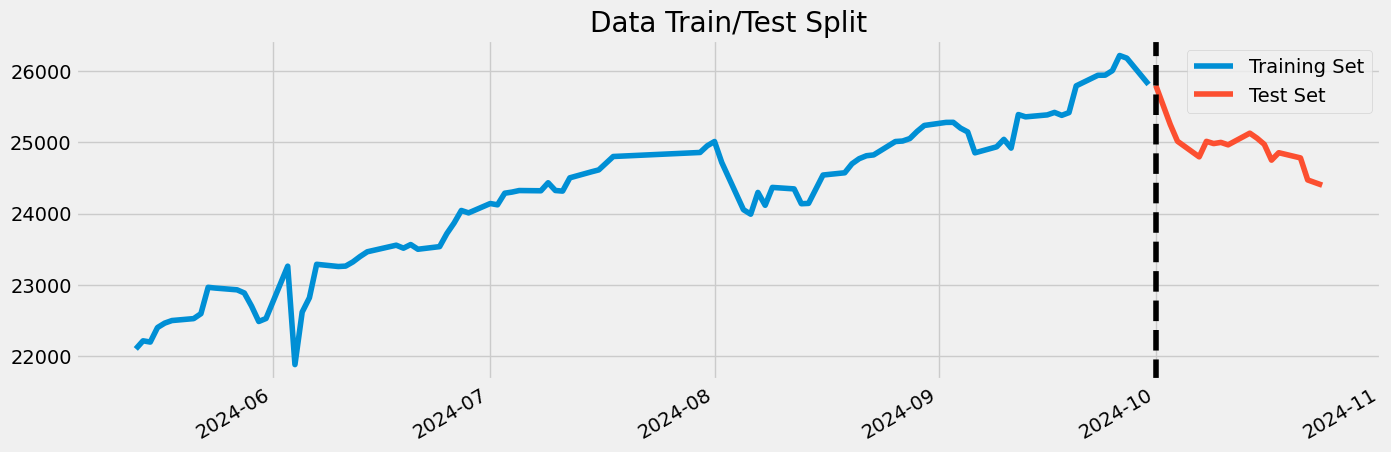

In [8]:
train_test_split_point = pd.to_datetime('2024-10-01')
train = work_df.loc[work_df.index < train_test_split_point]
test = work_df.loc[work_df.index >= train_test_split_point]

fig, ax = plt.subplots(figsize=(15, 5))
train['Close'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['Close'].plot(ax=ax, label='Test Set')
ax.axvline(train_test_split_point, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Model

In [9]:
FEATURES = work_df.columns.drop(['High', 'Low', 'Close', 'Daily_Change', 'Daily_change_percent'])
TARGET = 'Close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [10]:
reg = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=500,
    early_stopping_rounds=50,
    max_depth=10,
    learning_rate=0.05
)
reg.fit(X_train, y_train, verbose=100, eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:1024.78976	validation_1-rmse:760.01427
[93]	validation_0-rmse:28.10207	validation_1-rmse:177.67804


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Forecasting

/var/folders/8m/7v6gzd016pvd5cfs456xwjvc0000gn/T/ipykernel_46293/3558726457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


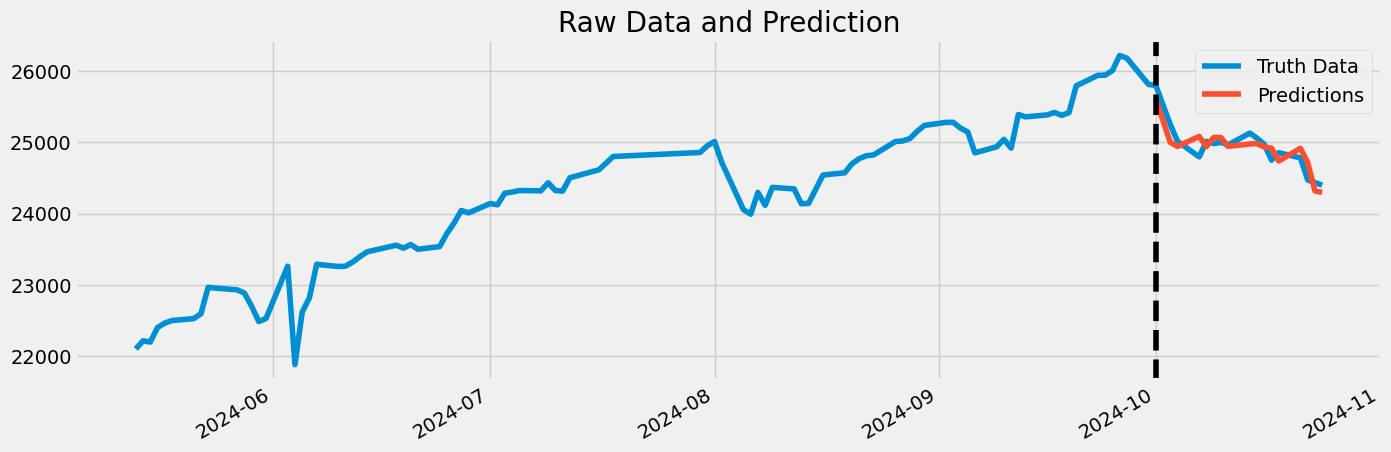

In [11]:
test['prediction'] = reg.predict(X_test)
work_df = work_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = work_df[[TARGET]].plot(figsize=(15, 5))
work_df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
ax.axvline(train_test_split_point, color='black', ls='--')
plt.show()

## Evaluation

In [12]:
score = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 149.13


## Analysis

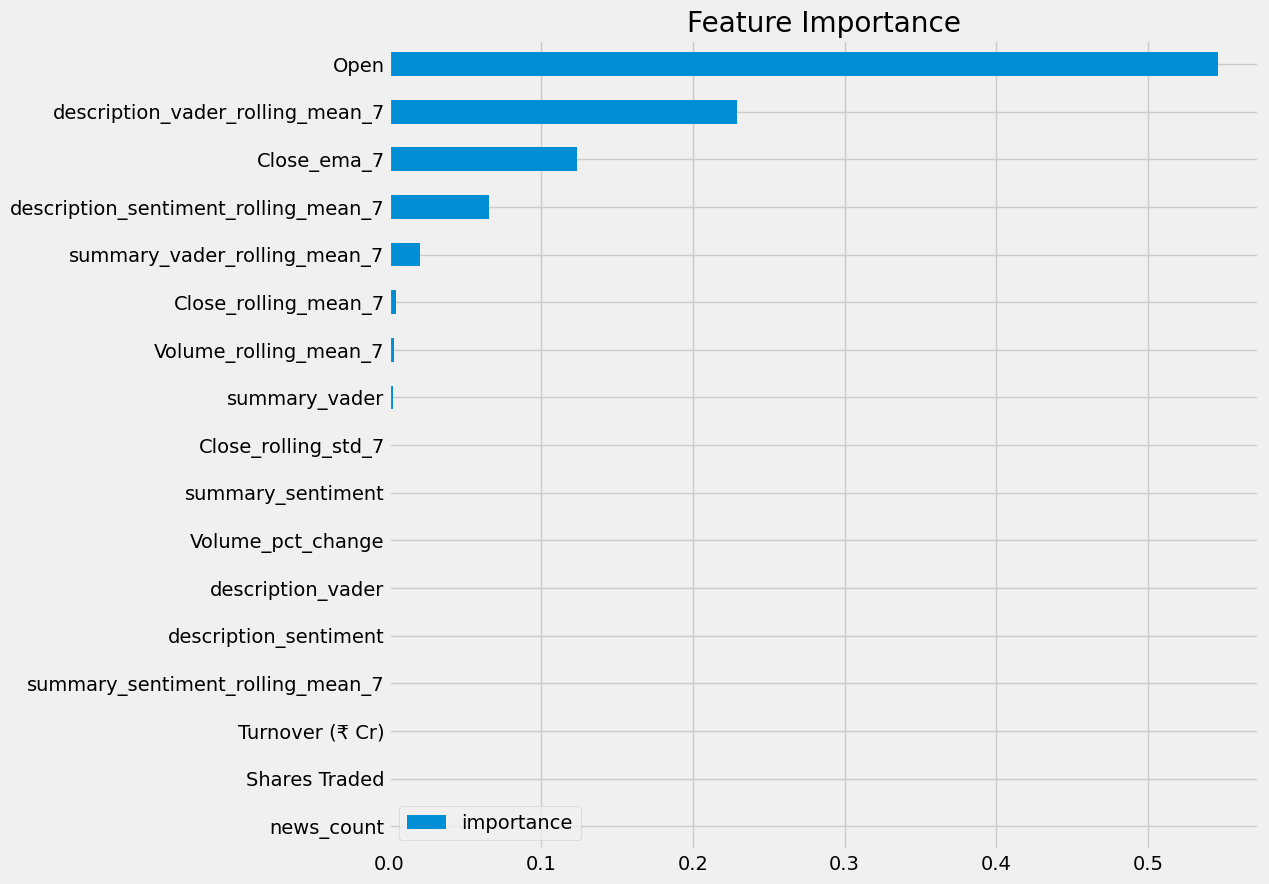

In [13]:
fi = pd.DataFrame(data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(10, 10))
plt.show()

In [14]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-10-07    286.250000
2024-10-03    250.281641
2024-10-22    244.003516
2024-10-01    193.124609
2024-10-17    167.241797
2024-10-14    151.553516
2024-10-21    134.816016
2024-10-23    116.958984
2024-10-18    115.536328
2024-10-24    102.142188
Name: error, dtype: float64

In [ ]:
reg.save_model('../Models/market_forecasting/xgboost_forecaster.model')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [14:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
